# <h1><center>*Predicting Bitcoin's Price*</center></h1>

# Goals:

- Identify if there is a correlation between BTC (Bitcoin), DJI (Dow Jones Industrial Average), and Gold 
- Build a model to best predict BTC's price in the next 6 months
 ___

# Imports

In [11]:
import pandas as pd
import numpy as np 

import yfinance as yf
import mplfinance as mpf
import acquire as a
import prepare as p

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt 

from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

---------------------------------------------------------------------------------------------------------------

# Acquire

 - Data acquired through Yahoo Finance Library
 - Wrote a function in my acquire.py file that includes to extract the data
 - Combined the 3 different dataframes
 - It contained 2,085 rows and 3 columns before cleaning
 - Each row represents a specific day in the dataset
 - Each column represents the price related to each asset 
 
 __________

# Prepare

 - Checked for nulls in the data(there were none)
 - Checked that column data types were appropriate
 - Renamed columns
 - Resampled data into Yearly, Quarterly, Monthly and assigned to their respective variables
 - Split data into train, validate and test (approx. 50/30/20)
 
 _____

# Data Dictionary


| Target Variable |     Definition     |
| --------------- | ------------------ |
|      btc_price    | price of Bitcoin |

| Feature  | Definition |
| ------------- | ------------- |
| open | Opening price of the asset |
| high | The high price point of the asset  |
| low | The low price point of the asset |
| close | The closing price of the asset |
| adj close | The closing price after adjustments |
| volume | The amount of an asset that changes hands | 
| dji_price | The price of the Dow Jones Industrial Average |
| gold | The price of gold per ounce|

_____

# A brief look at the data

In [2]:
# acquiring and merging the necessary data 
btc_df, gold_df, dji_df = a.asset_price(2010)
df = a.merged_assets(btc_df, gold_df, dji_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# preparing and cleaning the data
df, df_year, df_month, df_quarter = p.clean_df(df)

In [4]:
df

,btc_price,gold_price,dji_price
date,,,
2014-09-17,457.33,1234.4,17156.85
2014-09-18,424.44,1225.7,17265.99
2014-09-19,394.80,1215.3,17279.74
2014-09-22,402.15,1216.8,17172.68
2014-09-23,435.79,1221.0,17055.87
...,...,...,...
2022-12-23,16796.95,1795.9,33203.93
2022-12-27,16717.17,1814.8,33241.56
2022-12-28,16552.57,1807.9,32875.71


In [9]:
# splitting data into train, validate, and test
train, validate, test = p.split_data_explore(df)
train.shape, validate.shape, test.shape

((1042, 3), (626, 3), (417, 3))

In [10]:
#displaying all columns and getting first 5 rows
train.head()

,btc_price,gold_price,dji_price
date,,,
2014-09-17,457.33,1234.4,17156.85
2014-09-18,424.44,1225.7,17265.99
2014-09-19,394.80,1215.3,17279.74
2014-09-22,402.15,1216.8,17172.68
2014-09-23,435.79,1221.0,17055.87


# A summary of the data

In [ ]:
# a look at our column names, data types, and null counts
train.info()

# Explore

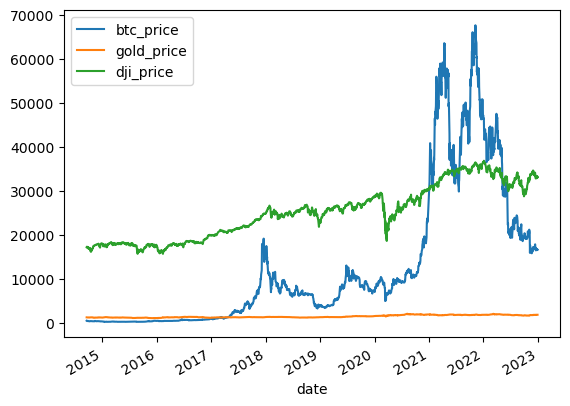

In [14]:
df.plot()
plt.show()

### *1. Will more bedrooms and bathrooms drive house value up?*

In [ ]:
# a bar plot showing us bathrooms compared to their respective home prices
e.plot_categorical_and_continuous_vars(df, 'bathrooms', 'home_value')

In [ ]:
# a bar plot showing us bedrooms compared to their respective home prices
e.plot_categorical_and_continuous_vars(df,'bedrooms', 'home_value')

**Takeaways**

- As bedrooms and bathrooms increase in a home, it seems like the price of the home increase

____

### *2. Does lot size sqft increase home value?*

In [ ]:
# # a scatter plot showing us a relationship between lot sqft to home prices
e.lm_plot(df)

**Takeaways**

- It seems like as lot sqft goes up so does the price, but the correlation does not seem to be strong


--------

### *3. Does the month of the transaction affect the price of the home?*

In [ ]:
# a bar plot showing us the transaction months to home prices
e.plot_categorical_and_continuous_vars(df, 'transaction_month', 'home_value')

**Takeaways**

- It seems like September had the highest home price value followed by June.

**Ran a pearsonr test to evaluate if there is relationship between transaction month and house value** <br>

$H_0$: There is no relationship between home price and the month of the transaction<br>
$H_a$: There is a relationship between the month of the transaction of the home and the price

 - Confidence interval of 95%
 - Alpha is .05


**Takeaways**

- We reject the null hypothesis, meaning there is a relationship between transaction date and home value. Transaction date will be moved forward for modeling

_____

### *4. Are Orange County home values higher compared to Los Angeles and Ventura County home values?*


In [ ]:
# a bar plot showing us counties to home prices
e.plot_categorical_and_continuous_vars(df, 'county', 'home_value')

In [ ]:
# a scatter plot using latitude and longitude to map out homes in their counties
e.outline(df)

**Takeaways**

- It seems like Orange County homes are more expensive than the other two counties

**Ran a one sample t test to evaluate if Oragne County Homes are more expensive than Los Angeles and Ventura** <br>

$H_0$: Orange County home values are <= Los Angeles and Ventura home values<br>
$H_a$: Orange County home values are > than Los Angeles and Ventura home values

 - Confidence interval of 95%
 - Alpha is .05


In [ ]:
# calling a function from explore.py to run a one sample t test
e.county_stats_test(train)

**The p-value is more than the Alpha. Therefore, we have strong support that Orange County homes are greater in value compared to Los Angeles and Ventura.**

----

# Exploration Summary

**- Bedrooms, bathrooms, lot sqft, transaction month, and county were found to be features that affect the home value**<br>
**- All features will be added for the modeling phase<br>**
**- County and transaction month seem to have the strongest influence.**
 
 ------

# Modeling 

- Goal is to minimize RMSE, so this will be my evaluation metric
- Ran 3 models including a Linear Regression , LassoLars, and a Polynomial 
- Before modeling scaled data and split
- I evaluated the models on train and validate data 
- The best performing model then was evaluated on test data subset

In [ ]:
# wrote a function to scale my train, validate, and test data subsets
train_scaled, validate_scaled, test_scaled = m.mvp_scaled_data(train, validate, test)

In [ ]:
# looking at one line of data in our scaled data
train_scaled.head(1)

In [ ]:
# calling a function I wrote in my modeling.py to split my data in to X/y train, validate, test
X_train, y_train, X_validate,y_validate, X_test, y_test = m.splitting_subsets(train, train_scaled, validate_scaled, test_scaled)

In [ ]:
# a look to 1st observation of our scaled, split, train subset
X_train.head(1)

In [ ]:
# called my function that in my modeling.py to demostrate my 3 best models and the baseline
# this includes the train rmse, validate rmse, and their difference 

m.best_models(X_train, y_train, X_validate, y_validate)

### Modeling Summary & Evaluation 

**The best performing model is the linear polynomial, so we tested the model with the test data**

In [ ]:
# this is the best model and ran the test data on it
m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

------

<div class="alert alert-info">
    <header>
    <h2>Conclusions:</h2>    
</header>    
<dt>
    
Home value predictions were used by minimizing RMSE within our models. County and transaction month have proven to be the most valuable, but there is still room for improvement.
<br>        
Best Model's performance:

- My best model reduced the root mean squared error by 82500 dollars compared to the baseline results.

- RMSE 82493.41 dollars on in-sample (train), RMSE 84100.76 dollars on out-of-sample data (validate) and RMSE of 80897.87 dollars on the test data.</dt>

<header>
    <h2>Recommendations:</h2>        
</header>      
<dl>
    
- I would recommend using counties and transaction months to build models to predict home values. 

- I would also recommend collecting more data about the homes. For example, crime rates in the county, average salary within neighborhoods, and school rankings.
 

<header>
    <h2> Next Steps:</h2>       
</header> 
</dl>
    
- I would add more columns/features from the database to see if there are better relationships to help predict price.

- Consider adding different hyperparameters to models for better results.  

</div>